libs

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import callbacks
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

print('\u2022 Using TensorFlow Version:', tf.__version__)

• Using TensorFlow Version: 2.7.0


Preparing the data

In [13]:
# Define Constants
TRAIN_PATH = './DFU/train'
TEST_PATH = './DFU/TestSet'
VALIDATION_PATH = './DFU/validation'
BATCH_SIZE = 64
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
NUM_CLASSES = 2
EPOCHS = 100


# Load the Training and Validation Dataset
train_ds = image_dataset_from_directory(
    TRAIN_PATH,
    labels = 'inferred',
    batch_size = BATCH_SIZE,
    image_size = (IMAGE_WIDTH, IMAGE_HEIGHT)
)

validation_ds = image_dataset_from_directory(
    VALIDATION_PATH,
    labels = 'inferred',
    batch_size = BATCH_SIZE,
    image_size = (IMAGE_WIDTH, IMAGE_HEIGHT)
)

Found 808 files belonging to 2 classes.
Found 247 files belonging to 2 classes.


Looking at the data

In [14]:
# Load Test Dataset
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH])

def process_path(file_path):
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img

test_ds = tf.data.Dataset.list_files(str(TEST_PATH + '/*'), shuffle=False)
# test_ds = test_ds.shuffle(len(os.listdir(TEST_PATH)), reshuffle_each_iteration=False)
test_ds = test_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

# Get the class names
class_names = train_ds.class_names
print(class_names)

['Abnormal', 'normal']


In [ ]:
# Visualize the testing dataset
plt.figure(figsize = (10, 10))

i = 0
for images in test_ds.take(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images.numpy().astype("uint8"))
    plt.axis("off")
    i += 1

Data augumentation 

In [ ]:
# Layers of Augmentation
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor = 0.15),
        layers.RandomTranslation(height_factor = 0.1, width_factor = 0.1),
        layers.RandomFlip(),
        layers.GaussianNoise(stddev = 0.09),
        layers.RandomContrast(factor = 0.1),
    ],
    name = "img_augmentation"
)


# View the augmentations
plt.figure(figsize = (10, 10))
for image, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image[0], axis = 0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")

# Caching and Prefetching (Optimization)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [24]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

Building a small model 

In [32]:

model = tf.keras.models.Sequential([
    layers.Rescaling(1./255, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(NUM_CLASSES)
])
model.summary()




Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_28 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 56, 56, 64)       

compiling the model

In [33]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.0, nesterov=False, name='SGD'),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_28 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 56, 56, 64)       

training the model

In [35]:
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=10
)

Epoch 1/10
13/13 [==============================] - 28s 2s/step - loss: 0.6710 - accuracy: 0.7054 - val_loss: 0.6654 - val_accuracy: 0.6599
Epoch 2/10
13/13 [==============================] - 17s 1s/step - loss: 0.6681 - accuracy: 0.6955 - val_loss: 0.6621 - val_accuracy: 0.6842
Epoch 3/10
13/13 [==============================] - 17s 1s/step - loss: 0.6652 - accuracy: 0.6993 - val_loss: 0.6587 - val_accuracy: 0.7166
Epoch 4/10
13/13 [==============================] - 23s 2s/step - loss: 0.6623 - accuracy: 0.7116 - val_loss: 0.6556 - val_accuracy: 0.7247
Epoch 5/10
13/13 [==============================] - 22s 2s/step - loss: 0.6596 - accuracy: 0.7129 - val_loss: 0.6527 - val_accuracy: 0.7409
Epoch 6/10
13/13 [==============================] - 19s 1s/step - loss: 0.6570 - accuracy: 0.7240 - val_loss: 0.6497 - val_accuracy: 0.7449
Epoch 7/10
13/13 [==============================] - 17s 1s/step - loss: 0.6545 - accuracy: 0.7277 - val_loss: 0.6468 - val_accuracy: 0.7530
Epoch 8/10
13/13 [==

Visualize training results

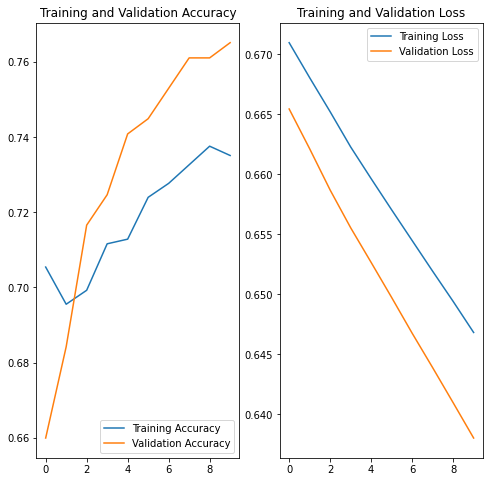

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Predict on new data

In [43]:
img_path = './DFU/Original_Images/2.jpg'

img = tf.keras.utils.load_img(
    img_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Abnormal with a 54.19 percent confidence.
